In [1]:
import os
import pickle
import random
import torch
from models.gait_fc import GaitFC, GaitFCV2
import numpy as np


In [2]:
root = 'gait_fc_dataset/test_p2'
ids = os.listdir(root)
print(len(ids))

videos_db = []
target_db = []

video_at = []
target_at = []

for idx in ids:

    # print(idx)
    videos = os.listdir(os.path.join(root, idx))
    videos = [os.path.join(root, idx, v) for v in videos]

    scale = int(len(videos)/2)

    video_at += videos[:scale]
    target_at += [int(idx)] * len(videos[:scale])

    videos_db += videos[scale:]
    target_db += [int(idx)] * len(videos[scale:])

# print(set(idd).__len__())

print(len(videos_db), len(video_at))
print(len(target_db), len(target_at))

print(len(set(target_db)))
print(len(set(target_at)))

73
1990 1957
1990 1957
73
73


In [3]:
def calc_euclidean(feat1, feat2):
    feat1 = feat1.ravel()
    feat2 = feat2.ravel()
    return torch.dot(feat1, feat2) / (torch.linalg.norm(feat1) * torch.linalg.norm(feat2))

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

device = torch.device('cpu')
model = GaitFCV2()
model.load_state_dict(torch.load('src/gait_fcv2_epoch_27.pt'))

# model = GaitFCV2()
# model.load_state_dict(torch.load('src/gait_fcv2_epoch_50.pt'))
model.to(device)
model.eval()

GaitFCV2(
  (gei_encoder): MobileFaceNet(
    (layers): ModuleList(
      (0): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=64)
        )
      )
      (1): ConvBlock(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=64)
        )
      )
      (2): DepthWise(
        (layers): Sequential(
          (0): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): PReLU(num_par

In [4]:
def preprocess(vid):
    with open(vid, 'rb') as handle:
        anchor_vid = pickle.load(handle)
        a_v = anchor_vid['ae_feat']
        a_v = softmax(a_v)
        a_gei = anchor_vid['gei']
        a_gei = np.expand_dims(a_gei, axis=0)/40
    a_v = torch.from_numpy(a_v).float()
    a_gei = torch.from_numpy(a_gei).float()
    return a_v, a_gei

a_v, a_gei = preprocess('gait_fc_dataset/test/0/000.pkl')
feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))
print(feat)

tensor([[ 4.5164e-02,  9.3084e-02,  7.3875e-02, -9.5822e-02,  3.4642e-02,
          2.9182e-02, -4.4587e-02, -1.1725e-02, -8.7492e-02,  2.9608e-04,
          5.9329e-02, -6.0872e-02, -2.7436e-02,  4.4770e-02,  1.2796e-03,
         -8.6126e-02, -1.8185e-02,  6.8145e-03,  1.1460e-01, -1.0944e-02,
         -5.9417e-02, -1.2702e-02, -8.6172e-02, -1.1346e-03,  5.8882e-02,
          4.6735e-02, -6.2541e-02,  1.4308e-01,  4.3904e-02, -5.6263e-02,
         -5.4706e-02,  3.3687e-02,  1.0509e-02, -5.5668e-02,  8.0472e-02,
          1.5240e-01,  6.2602e-02, -6.9069e-02,  4.3618e-02,  3.4276e-02,
         -4.9288e-02, -1.2192e-01, -8.6704e-03,  2.7144e-02, -9.5676e-02,
          1.7085e-01,  2.5639e-02, -6.4406e-02,  9.6724e-02,  4.1294e-02,
          3.6610e-02,  3.8325e-02,  1.0929e-01,  5.4792e-02, -2.3233e-02,
          3.4548e-03, -1.9993e-02,  3.8035e-02, -1.1853e-01, -9.8928e-02,
          9.3222e-02,  1.5096e-02,  9.5566e-02, -4.1409e-02, -1.1692e-01,
          4.5675e-02,  8.9747e-03, -3.

C:\Users\Cuong Tran\AppData\Roaming\Python\Python38\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


# DB get embed

In [5]:
embeddings_db = []
target_embed_db = []
with torch.no_grad():
    for idx, vid in zip(target_db, videos_db):
        a_v, a_gei = preprocess(vid)
        # print(a_v.shape)
        # print(a_gei.shape)
        feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))
        embeddings_db.append(feat[0])
        target_embed_db.append(idx)
        # break

print(len(embeddings_db))

1990


# AT Get embed


In [9]:
embeddings_at = []
target_embed_at = []
with torch.no_grad():
    for idx, vid in zip(target_at, video_at):
        a_v, a_gei = preprocess(vid)
        # print(a_v.shape)
        # print(a_gei.shape)
        feat = model(a_v.unsqueeze(0).to(device), a_gei.unsqueeze(0).to(device))
        embeddings_at.append(feat[0])
        target_embed_at.append(idx)
        # break

print(len(embeddings_at))

C:\Users\Cuong Tran\AppData\Roaming\Python\Python38\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1957


# ROC and ERR

In [46]:
truth = []
pred = []
pred_score = []

thress = 0.3

false_over_thress = 0

d_means = []

for name, feat in zip(target_embed_at, embeddings_at):
    one_hot = [0]*len(set(target_embed_db))
    one_hot[name] = 1

    one_hot_pred = [0]*len(set(target_embed_db))

    max_d = 0
    pred = 73
    for t, a in zip(target_embed_db, embeddings_db):
        d = calc_euclidean(feat, a)
        if d.item() > one_hot_pred[t]:
            one_hot_pred[t] = d.item()
        if d>max_d:
            # print(t, d)
            max_d = d
            pred = t
    # print(max(one_hot_pred))
    # print(len(one_hot_pred))
    # print(one_hot_pred.index(max(one_hot_pred)))
    # print(pred)
    # print(one_hot_pred, one_hot)
    truth.append(one_hot)
    pred_score.append(one_hot_pred)
    # break

# print(false_over_thress)

In [49]:
truth = np.array(truth)
pred_score = np.array(pred_score)

In [ ]:
print(pred_score[-1])

0.037387186424806054 0.40015344301315203


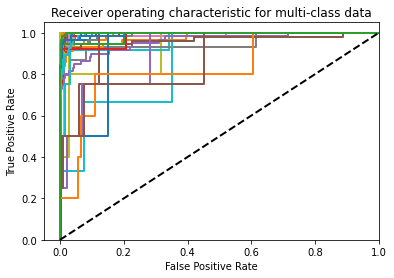

In [66]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
fnr = dict()
roc_auc = dict()
eer_threshold = dict()
eer = dict()
lw=2

for i in range(len(set(target_embed_db))):
    fpr[i], tpr[i], threshold = roc_curve(truth[:, i], pred_score[:, i])
    fnr[i] = 1 - tpr[i]

    roc_auc[i] = auc(fpr[i], tpr[i])
    eer[i] = fpr[i][np.nanargmin(np.absolute((1 - tpr[i]) - fpr[i]))]
    eer_threshold[i] = threshold[np.nanargmin(np.absolute((fnr[i] - fpr[i])))]

eer_threshold = np.array(list(eer_threshold.values()))
err = np.array(list(eer.values()))
print(err.mean(), eer_threshold.mean())


for i in range(len(set(target_embed_db))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
# plt.legend(loc="lower right")
plt.show()

In [13]:
print(eer_threshold)

0.026349299


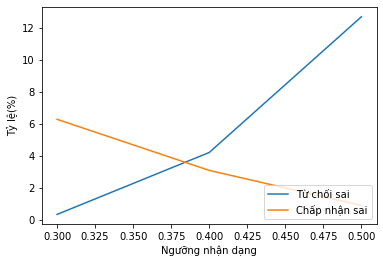

In [73]:
tuchoisai = np.array([0.35, 4.22, 12.70])
chapnhansai = np.array([1.07+5.22, 0.16+2.94, 0.02+0.89])

nguong = [0.3, 0.4, 0.5]

plt.plot(nguong, tuchoisai, label='Từ chối sai')
plt.plot(nguong, chapnhansai, label='Chấp nhận sai')
plt.legend(loc="lower right")
plt.xlabel('Ngưỡng nhận dạng')
plt.ylabel('Tỷ lệ(%)')
plt.show()